In [1]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import tqdm, trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose, walking_pose

import cv2


from flygym.util.decentralized_controller import (update_stepping_advancement, compute_leg_scores,
                                               rule1_corresponding_legs, rule2_corresponding_legs, rule3_corresponding_legs,
                                               rule1_weight, rule2_weight, rule2_weight_contralateral, rule3_weight, rule3_weight_contralateral,
                                               percent_margin)

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# Initialize simulation
run_time = 1
out_dir = Path("../decentralized_ctrl")

enable_adhesion = True

sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.1,
    render_fps=30,
    render_camera="Animat/camera_right",
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    draw_contacts=False,
    adhesion_off_duration=0.05,
)

nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

In [4]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
print('Dict keys:', data.keys())
print('Length of time series:', data['joint_RFCoxa'])
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1', 'swing_stance_time'])
Length of time series: [0.61922731 0.61871353 0.61819975 ... 0.63212368 0.6256755  0.61922731]
Metadata: {'timestep': 0.0001, 'source': 'Analyze_step_data.i

In [6]:
# Interpolate 5x
num_steps_base = int(run_time / nmf.timestep)
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [7]:
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]

# get all swing stance starts and get the shortes swing possible
# Every leg needs to have the same stance start and swing start

swing_start = min(list(data["swing_stance_time"]["swing"].values()))/nmf.timestep
stance_start = max(list(data["swing_stance_time"]["stance"].values()))/nmf.timestep

leg_swing_starts = {}
leg_stance_starts = {}

for l in legs:
    leg_swing_starts[l] = swing_start
    leg_stance_starts[l] = stance_start

#leg_swing_starts, leg_stance_starts, position_data, touch_sensor_data = define_swing_stance_starts(nmf, data_block, use_adhesion=enable_adhesion, n_steps_stabil=2000)

In [8]:
# Initialize simulation
n_stabilisation_steps = 2000
# Run the simulation for a few steps to stabilise the system before starting the contoller
num_steps = num_steps_base + n_stabilisation_steps

#Define rule variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# For each leg the ids of the force sensors that are attached to it
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.contact_sensor_placements):
    for leg in legs:
        if leg in collision_geom:
            leg_force_sensors_ids[leg].append(i)   

In [9]:
np.random.seed(0)

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)

nmf.reset()

# Track the number of steps taken. It will be used to determine the stpping probability in the random stepper
number_of_taken_steps = 0
leg_scores = np.zeros(len(legs))

obs_list_cruse_flat = []
all_initiated_legs = []

adhesion_signal = np.zeros(6)
legs_to_adhesion = np.array([leg_corresp_id[ts[:2]] for ts in nmf.last_tarsalseg_names])
stance_starts_in_order = np.array([leg_stance_starts[ts[:2]] for ts in nmf.last_tarsalseg_names])
swing_starts_in_order = np.array([leg_swing_starts[ts[:2]] for ts in nmf.last_tarsalseg_names])

#Run the actual simulation
for i in trange(num_steps):

    #Decide in which leg to step
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1) or stepping_advancement[initiating_leg] > 0:
        initiating_leg = None
    else:
        stepping_advancement[initiating_leg] += 1
        all_initiated_legs.append([initiating_leg, i])
        number_of_taken_steps += 1
        #print("Stepping leg: ", legs[initiating_leg], " at step: ", i)
    
    joint_pos = data_block[joint_ids, stepping_advancement[match_leg_to_joints]]

    if enable_adhesion:
        adhesion = np.logical_or(stepping_advancement[legs_to_adhesion] < swing_starts_in_order,
                                            stepping_advancement[legs_to_adhesion] > stance_starts_in_order)
    else:
        adnesion = np.zeros(6)

    action = {'joints': joint_pos, "adhesion":adhesion}
    obs, info, _, _, _ = nmf.step(action)
    render_img = nmf.render()
    obs_list_cruse_flat.append(obs)

    stepping_advancement = update_stepping_advancement(stepping_advancement, legs, interp_step_duration)

    rule1_contrib, rule2_contrib, rule3_contrib  = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                                                      rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                                                      rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                                                      stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration, legs)
    
    all_legs_rule1_scores[:, i] = rule1_contrib
    all_legs_rule2_scores[:, i] = rule2_contrib
    all_legs_rule3_scores[:, i] = rule3_contrib

    leg_scores = rule1_contrib + rule2_contrib + rule3_contrib
        
    all_leg_scores[:, i] = leg_scores

nmf.save_video("outputs/rule_based.mp4", stabilization_time=n_stabilisation_steps * nmf.timestep)
nmf.close()

distances = obs_list_cruse_flat[n_stabilisation_steps]["fly"][0][:2] - obs_list_cruse_flat[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [00:28<00:00, 418.23it/s]


Forward distance travelled:  -6.303835928973557
Lateral distance travelled:  0.6477478471275958


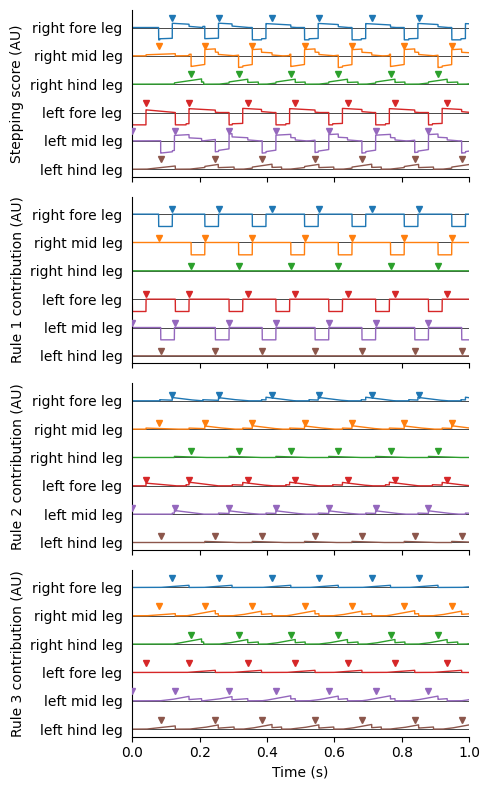

In [10]:
scores = {
    "Stepping score": all_leg_scores[:, n_stabilisation_steps:],
    "Rule 1 contribution": all_legs_rule1_scores[:, n_stabilisation_steps:],
    "Rule 2 contribution": all_legs_rule2_scores[:, n_stabilisation_steps:],
    "Rule 3 contribution": all_legs_rule3_scores[:, n_stabilisation_steps:],
}
time = np.arange(scores["Stepping score"].shape[1]) * nmf.timestep
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}
leg_basey_lookup = {
    "right fore leg": 0,
    "right mid leg": -1,
    "right hind leg": -2,
    "left fore leg": -3,
    "left mid leg": -4,
    "left hind leg": -5,
}
leg_name_lookup = {
    "RF": "right fore leg",
    "LF": "left fore leg",
    "RM": "right mid leg",
    "LM": "left mid leg",
    "RH": "right hind leg",
    "LH": "left hind leg",
}

def plot_frame(current_time=None, video_layout=False):
    if video_layout:
        fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True, tight_layout=True)
    else:
        fig, axs = plt.subplots(4, 1, figsize=(5, 8), sharex=True, sharey=True, tight_layout=True)
    for i, (score_name, score_ts) in enumerate(scores.items()):
        ax = axs.flatten()[i]
        for j, leg in enumerate(legs):
            offset = leg_basey_lookup[leg_name_lookup[leg]] * 23000
            ax.plot(time, score_ts[j, :] + offset, label=leg, color=color_lookup[leg], linewidth=1)
            ax.axhline(offset, color="k", linestyle="-", linewidth=0.5, zorder=-1)
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 23000)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
        ax.set_xlim(0, 1)
        ax.set_ylabel(f"{score_name} (AU)")
        if video_layout:
            ax.set_title(score_name)
        if i == 3 or (i == 1 and video_layout):
            ax.set_xlabel("Time (s)")

        for leg_index, step in all_initiated_legs:
            leg = legs[leg_index]
            step_time = time[step - n_stabilisation_steps]
            marker_heihgt = score_ts[j, :].max() + 4000
            offset = leg_basey_lookup[leg_name_lookup[leg]] * 23000
            ax.plot(step_time, offset + marker_heihgt, "v", color=color_lookup[leg], zorder=10, markersize=5)
        ax.tick_params(left=False)

        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)

    sns.despine()
    return fig

plt.style.use("default")
fig = plot_frame()
fig.savefig("outputs/rule_based.pdf", transparent=True)

In [11]:
plt.style.use("dark_background")

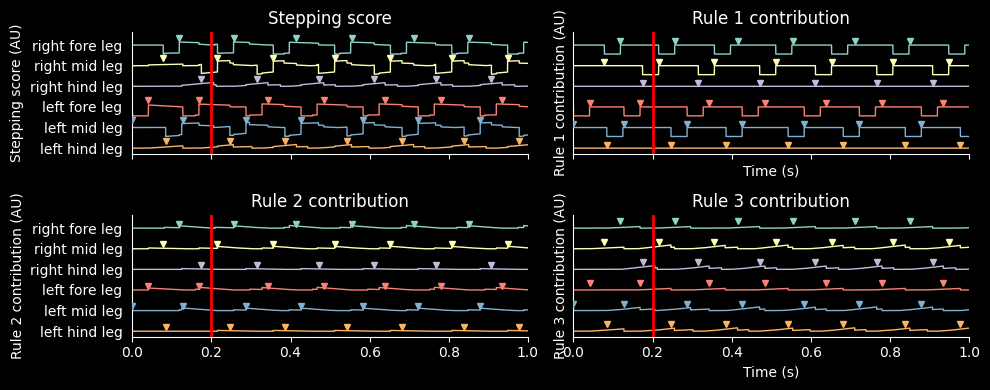

In [12]:
fig = plot_frame(current_time=0.2, video_layout=True)

In [13]:
def matplotlib_figure_to_array(fig):
    """Adapted from https://stackoverflow.com/a/67823421/13560623"""
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    return data.reshape((int(h), int(w), -1))

In [14]:
def merge_frame_and_time_series(i, frame):
    current_time = i * nmf._eff_render_interval
    time_series_fig = plot_frame(current_time, video_layout=True)
    time_series_img = matplotlib_figure_to_array(time_series_fig)
    plt.close(fig=time_series_fig)
    assert frame.shape[0] >= time_series_img.shape[0]
    height = time_series_img.shape[0]
    frame_width = int(height * frame.shape[1] / frame.shape[0])
    frame = cv2.resize(frame, (frame_width, height))
    merged_frame = np.concatenate([frame, time_series_img[:, :, :3]], axis=1)
    return merged_frame

In [15]:
n_frames_to_drop = int(n_stabilisation_steps * nmf.timestep / nmf._eff_render_interval)
frames_to_render = nmf._frames[n_frames_to_drop:]
video_shape = merge_frame_and_time_series(0, frames_to_render[0]).shape

out = cv2.VideoWriter(
    "outputs/rule_based.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    sim_params.render_fps,
    (video_shape[1], video_shape[0]),
)

for i, frame in tqdm(enumerate(frames_to_render), total=len(frames_to_render)):
    merged_frame = merge_frame_and_time_series(i, frame)
    out.write(merged_frame[:, :, ::-1])  # RGB to BGR
out.release()

100%|██████████| 300/300 [01:35<00:00,  3.13it/s]
